# Assembling a FCN network

## Download data

In [1]:
!curl https://storage.googleapis.com/aiolympiadmy/ioai-2025-tsp/leaf-segmentation-dataset.zip -o leaf-segmentation-dataset.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
 10  417M   10 43.9M    0     0  41.7M      0  0:00:09  0:00:01  0:00:08 41.8M
 26  417M   26  111M    0     0  50.2M      0  0:00:08  0:00:02  0:00:06 50.2M
 34  417M   34  145M    0     0  47.2M      0  0:00:08  0:00:03  0:00:05 47.2M
 42  417M   42  176M    0     0  43.6M      0  0:00:09  0:00:04  0:00:05 43.6M
 53  417M   53  222M    0     0  44.1M      0  0:00:09  0:00:05  0:00:04 44.7M
 62  417M   62  258M    0     0  42.7M      0  0:00:09  0:00:06  0:00:03 42.9M
 73  417M   73  307M    0     0  43.6M      0  0:00:09  0:00:07  0:00:02 40.5M
 81  417M   81  339M    0     0  41.9M      0  0:00:09  0:00:08  0:00:01 38.7M
 92  417M   92  385M    0     0  42.6M      0  0:00

In [2]:
!unzip -n leaf-segmentation-dataset.zip

Archive:  leaf-segmentation-dataset.zip


## Load and inspect data

Data is given to you in a `trainval/` and `test/` subdir. Images are named `*_rgb.png` while their foreground masks (_what does this mean?_) are given in `*_fg.png`. 

Use this section to figure out what you need / want to know about the data.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [4]:
test_img = Image.open("./trainval/plant0421_rgb.png").convert("RGB")
test_mask = Image.open("./trainval/plant0421_fg.png").convert("L")

In [5]:
test_image_np = np.array(test_img)
test_mask_np = np.array(test_mask)

In [6]:
test_image_np.shape, test_mask_np.shape

((441, 441, 3), (441, 441))

In [7]:
np.unique(test_mask_np)

array([  0, 255], dtype=uint8)

In [8]:
test_mask_np = (test_mask_np > 0).astype(np.uint8)

In [9]:
def display_image(img, mask, transpose_img=False, transpose_mask=False):
    if transpose_img:  # HWC to CHW
        img = np.transpose(img, (1, 2, 0))
    if transpose_mask:
        mask = np.transpose(mask, (1, 2, 0))

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(img)
    axes[0].set_title("Image")
    axes[0].axis("off")

    mask = (mask > 0).astype(np.uint8)
    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title("Foreground Mask")
    axes[1].axis("off")

    mask_ch = mask if len(mask.shape) == 3 else mask[..., np.newaxis]
    mask_ch = np.repeat(mask_ch, img.shape[2], axis=2)
    axes[2].imshow(mask_ch * img)
    axes[2].set_title("Segmented Image")
    axes[2].axis("off")

    return fig, axes

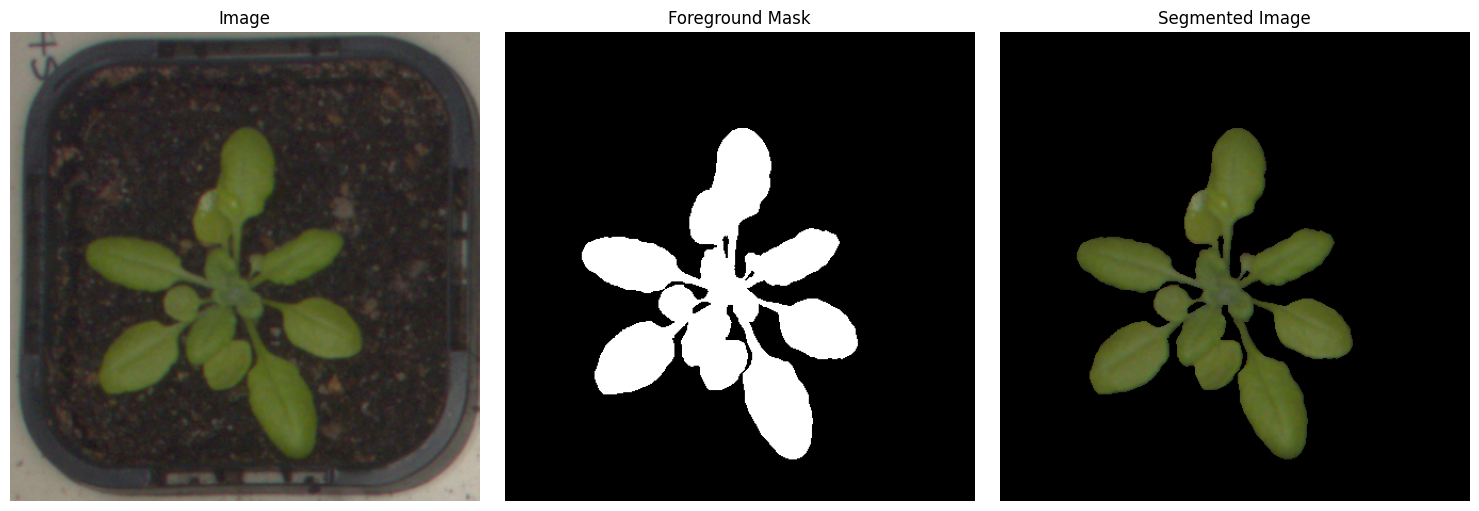

In [10]:
display_image(test_image_np, test_mask_np)
plt.tight_layout()

## Create your dataset and dataloaders

You've done the Pytorch 60 mins blitz right? Implement your dataset and dataloaders here. From the `trainval/` folder, split your data in an 80/20 split so that you have a train dataset and a validation dataset from this folder. Load your test dataset from `test/`.

You can test the shape of your tensors in the dataset like so:

```python
batch_X, batch_y = next(iter(train_dataset))
print(batch_X.shape, batch_y.shape)
```

Make sure your shape output makes sense!

> Albumentations requires Python 3.9 or higher.

We use Albumentations here as it is easier to ensure the image and mask undergo the same transformation than using `torchvision.transforms`.

In [11]:
import random
import albumentations as A
import cv2
from collections.abc import Sequence
from pathlib import Path
from functools import lru_cache
from torch.utils.data import Dataset, DataLoader
from albumentations.pytorch import ToTensorV2

In [12]:
class SegmentationDataset(Dataset):
    __slots__ = ("dir_", "transform", "images", "masks", "sizes", "__sequences")

    def __init__(self, dir_, proportions=(1,), transform=None):
        super().__init__()

        self.dir_ = Path(dir_)
        assert self.dir_.exists() and self.dir_.is_dir(), "image directory doesn't exist"

        self.images = sorted(self.dir_.glob("*_rgb.png"))
        self.masks = sorted(self.dir_.glob("*_fg.png"))
        assert len(self.images) == len(self.masks), "images and masks don't match"

        self.sizes = proportions
        tmp = sum(self.sizes)
        # Compute size for each chunk
        self.sizes = list(map(lambda x: int(x / tmp * len(self.images)), self.sizes))
        # Distribute the leftovers
        for idx in range(len(self.images) - sum(self.sizes)):
            self.sizes[idx] += 1

        random.seed(42)
        indices = list(range(0, sum(self.sizes)))
        random.shuffle(indices)
        self.__sequences = []

        start = 0
        for size in self.sizes:
            self.__sequences.append(indices[start:start + size])
            start += size

        self.transform = transform  # Only accept A.DualTransform transformations 

    def __len__(self):
        return len(self.images)

    def __setitem__(self, key, value):
        self.__dict__[key] = value
        self.__load_image.cache_clear()  # Clear cache when attribute is modified

    @lru_cache(maxsize=None)
    def __load_image(self, idx1, idx2):
        img_idx = self.__sequences[idx1][idx2]
        image = np.array(Image.open(self.images[img_idx]).convert("RGB"))
        mask = np.array(Image.open(self.masks[img_idx]).convert("L"))[..., np.newaxis]  # single-channel for mask
        mask = (mask > 0).astype(np.uint8)  # {0, 255} to {0, 1}
        if self.transform is not None:
            transform = self.transform
            if isinstance(transform, Sequence):
                transform = self.transform[idx1]
            image, mask = transform(image=image, mask=mask).values()
        return image, mask

    def __getitem__(self, key):
        if len(self.sizes) == 1 and isinstance(key, int):
            chunk, idx = 0, key
        else:
            chunk, idx = key

        if isinstance(idx, int):
            return self.__load_image(chunk, idx)
        results = []
        for mapped_idx in range(*idx.indices(self.sizes[chunk])):
            results.append(self.__load_image(chunk, mapped_idx))
        return results

    def chunked(self, chunk):
        class SegmentationDatasetWrapper(Dataset):
            def __init__(self, parent, chunk_idx):
                super().__init__()

                self.parent = parent
                self.chunk_idx = chunk_idx

            def __getitem__(self, idx):
                # Override: pass chunk as tuple
                return self.parent.__getitem__((self.chunk_idx, idx))

            def __len__(self):
                return self.parent.sizes[self.chunk_idx]

            def __getattr__(self, name):
                # fallback everything else to parent
                return getattr(self.parent, name)

        return SegmentationDatasetWrapper(self, chunk)

In [13]:
class ColorEnhance(A.ImageOnlyTransform):
    def __init__(self, lower_hsv, upper_hsv, enhance_factor=0.6, p=1.0):
        super().__init__(p=p)
        self.lower_hsv = np.array([
            self.remap(lower_hsv[0], 0, 359, 0, 179),
            self.remap(lower_hsv[1], 0, 100, 0, 255),
            self.remap(lower_hsv[2], 0, 100, 0, 255)
        ])
        self.upper_hsv = np.array([
            self.remap(upper_hsv[0], 0, 359, 0, 179),
            self.remap(upper_hsv[1], 0, 100, 0, 255),
            self.remap(upper_hsv[2], 0, 100, 0, 255)
        ])
        
        assert 0 <= enhance_factor <= 1, "'enhance_factor' should be a number between 0 and 1"
        self.enhance_factor = enhance_factor

    @staticmethod
    def remap(value, left_min, left_max, right_min, right_max):
        left_span = left_max - left_min
        right_span = right_max - right_min
        value_scaled = (value - left_min) / left_span
        return int(right_min + (value_scaled * right_span))

    def apply(self, image, **params):
        hsv_img = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

        mask = cv2.inRange(hsv_img, self.lower_hsv, self.upper_hsv) > 0  # Gives True, False
        mask = cv2.morphologyEx(mask.astype(np.uint8), cv2.MORPH_OPEN,
                                cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))).astype(bool)

        hsv_img[..., 2][~mask] = np.clip(hsv_img[..., 2][~mask] * (1 - self.enhance_factor), 0, 255)

        return cv2.cvtColor(hsv_img, cv2.COLOR_HSV2RGB)

In [14]:
def unnormalize(arr, transpose=True):  # Undo normalization, useful for displaying images
    if transpose:
        arr = np.transpose(arr, (1, 2, 0))

    # mean and std from ImageNet
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    arr = arr * (std[np.newaxis, np.newaxis, :] * 255) + (mean[np.newaxis, np.newaxis, :] * 255)
    return arr.astype(np.uint8)

In [15]:
def create_dataset(enhance_color=False, custom_train_transform=(A.NoOp(1.0), ), custom_valtest_transform=(A.NoOp(1.0), )):
    transforms = []
    for t in (custom_train_transform, custom_valtest_transform):
        transforms.append(A.Compose([
            A.Resize(height=224, width=224),
            *t,
            ColorEnhance((60, 20, 30), (145, 100, 100), 0.8) if enhance_color else A.NoOp(p=1.0),
            A.Normalize(),
            ToTensorV2(transpose_mask=True)
        ], seed=42))

    ds1 = SegmentationDataset("./trainval", (80, 20), transform=transforms)  # 80/20 split
    ds2 = SegmentationDataset("./test", transform=transforms[1])
    return ds1, ds2

In [16]:
ds_trainval, ds_test = create_dataset(enhance_color=True)

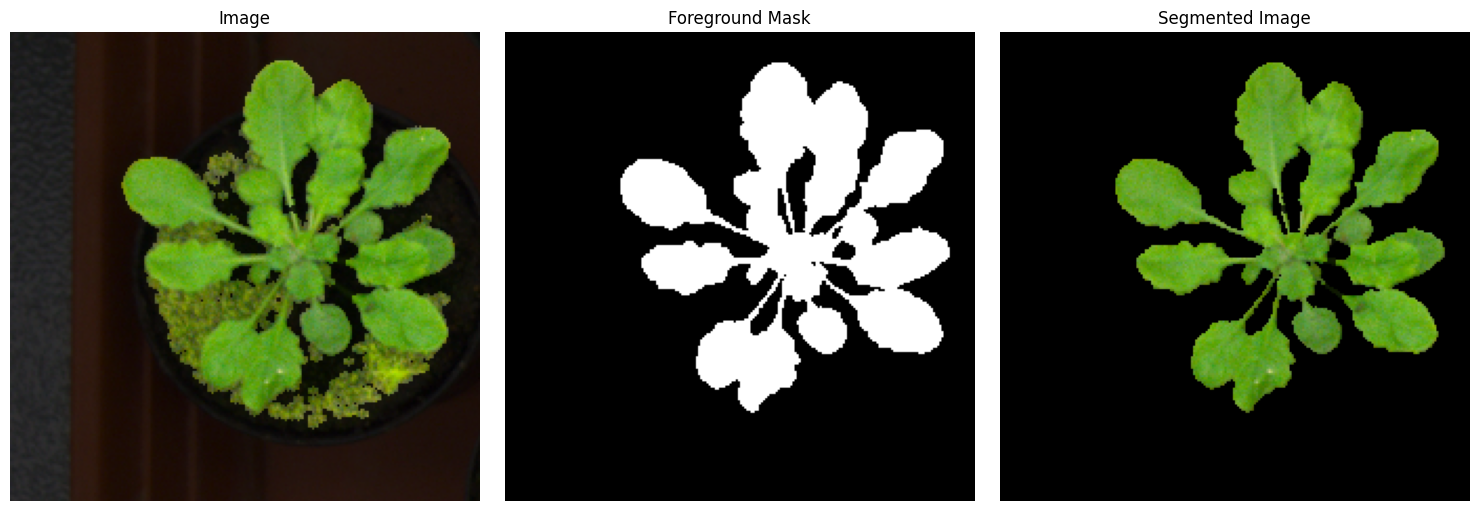

In [17]:
# test set, 42th image and mask
test_img, test_mask = ds_test[42]
test_img, test_mask = unnormalize(test_img.numpy(), transpose=True), test_mask.numpy()
display_image(test_img, test_mask, transpose_mask=True)
plt.tight_layout()

> The cell below may take a few seconds to run the first time. Subsequent runs will be instant due to caching.

In [18]:
sum(1 for _ in ds_trainval[0, :])  # How big is the train set?

500

In [19]:
def create_dataloader(ds1, ds2):
    dl1 = DataLoader(ds1.chunked(0), batch_size=64)  # train set
    dl2 = DataLoader(ds1.chunked(1), batch_size=64)  # val set
    dl3 = DataLoader(ds2, batch_size=64)  # test set
    return dl1, dl2, dl3

In [20]:
dl_train, dl_val, dl_test = create_dataloader(ds_trainval, ds_test)

In [21]:
for batch_X, batch_y in dl_train:
    print(batch_X.shape, batch_y.shape)  # Is the shape of each batch correct?

torch.Size([64, 3, 224, 224]) torch.Size([64, 1, 224, 224])
torch.Size([64, 3, 224, 224]) torch.Size([64, 1, 224, 224])
torch.Size([64, 3, 224, 224]) torch.Size([64, 1, 224, 224])
torch.Size([64, 3, 224, 224]) torch.Size([64, 1, 224, 224])
torch.Size([64, 3, 224, 224]) torch.Size([64, 1, 224, 224])
torch.Size([64, 3, 224, 224]) torch.Size([64, 1, 224, 224])
torch.Size([64, 3, 224, 224]) torch.Size([64, 1, 224, 224])
torch.Size([52, 3, 224, 224]) torch.Size([52, 1, 224, 224])


## Create the network

Define an FCN network by completing the class definition below.

Use a ResNet34 pretrained on ImageNet as the backbone, taking care to remove the final pooling layer and dense layer.

Make sure that the FCN head's tensor input size is the same as the backbone's output size.

Specify the FCN head with two layers:
+ a 1x1 convolution layer, to transform the number of output channels into the number of segmentation classes
+ a transpose convolution layer to upsample the feature maps to the size of the input image. Add a bilinear interpolation here if you need it (I did not work out the math on the image sizing, that's left to you)

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [23]:
class FCN(nn.Module):
    def __init__(self, backbone, head):
        super().__init__()
        self.backbone = backbone
        self.head = head

    def forward(self, x):
        x = self.backbone(x)
        x = self.head(x)
        return x

### Explore

In [24]:
from torchvision import models
from torchvision.models import ResNet34_Weights

In [25]:
resnet = models.resnet34(weights=ResNet34_Weights.DEFAULT)

In [26]:
# Remove final layers
resnet.avgpool = nn.Identity()
resnet.fc = nn.Identity()

In [27]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [28]:
def resnet_traversal(resnet_model):
    children = list(resnet_model.named_children())
    if not children:
        yield resnet_model
    else:
        for name, child in children:
            if name == "downsample":  # See details below
                continue
            yield from resnet_traversal(child)

In the traversal above , the `downsample` block is skipped because it is a shortcut connection used for residual addition. It doesn't represent a distinct forward path layer like the main `conv` or `maxpool` layers.

Here is the implementation from the `forward` method in the `torchvision.models.resnet.BasicBlock` class:

```python
def forward(self, x: Tensor) -> Tensor:
    identity = x

    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)

    out = self.conv2(out)
    out = self.bn2(out)

    if self.downsample is not None:
        identity = self.downsample(x)

    out += identity
    out = self.relu(out)

    return out
```
*(quoted from [pytorch.org](https://pytorch.org/vision/stable/_modules/torchvision/models/resnet.html))*

In [29]:
def compute_output_shape(layers, *, h, w, c):
    for layer in layers:
        if isinstance(layer, (nn.Conv2d, nn.MaxPool2d)):
            p, d, k, s = map(lambda x: (x, x) if isinstance(x, int) else x,
                             (layer.padding, layer.dilation, layer.kernel_size, layer.stride))

            h = int((h + 2 * p[0] - d[0] * (k[0] - 1) - 1) / s[0] + 1)
            w = int((w + 2 * p[1] - d[1] * (k[1] - 1) - 1) / s[1] + 1)
            if isinstance(layer, nn.Conv2d):
                c = layer.out_channels  # MaxPool2d doesn't change channel size
        elif isinstance(layer, nn.ConvTranspose2d):
            p, d, k, s, op = map(lambda x: (x, x) if isinstance(x, int) else x,
                                 (layer.padding, layer.dilation, layer.kernel_size, layer.stride, layer.output_padding))

            h = (h - 1) * s[0] - 2 * p[0] + d[0] * (k[0] - 1) + op[0] + 1
            w = (w - 1) * s[1] - 2 * p[1] + d[1] * (k[1] - 1) + op[1] + 1
            c = layer.out_channels
        elif isinstance(layer, nn.Unflatten):
            for dim_idx, dim_size in enumerate(layer.unflattened_size, layer.dim):
                if dim_idx == 1:
                    c = dim_size
                elif dim_idx == 2:
                    h = dim_size
                elif dim_idx == 3:
                    w = dim_size
                else:
                    raise NotImplementedError(f"can't handle '{layer.__class__.__name__}' with dim={layer.dim}")
        elif isinstance(layer, nn.Upsample):
            size = layer.size
            if isinstance(size, int):
                size = (size, size)
            scale_factor = layer.scale_factor
            if isinstance(scale_factor, (int, float)):
                scale_factor = (scale_factor, scale_factor)

            if not ((size is None) ^ (scale_factor is None)):
                raise ValueError(f"ambiguous settings of 'size' and 'scale_factor' in {layer.__class__.__name__}")
            elif scale_factor is not None:
                h = int(h * scale_factor[0])
                w = int(w * scale_factor[0])
            elif size is not None:
                h = size[0]
                w = size[0]
        elif isinstance(layer, (nn.BatchNorm2d, nn.ReLU, nn.Identity, nn.Sigmoid)):
            pass  # No change in sizes
        else:
            raise NotImplementedError(f"can't handle '{layer.__class__.__name__}'")
    return c, h, w

In [30]:
compute_output_shape(resnet_traversal(resnet), c=3, h=224, w=224)

(512, 7, 7)

In [31]:
fcn = FCN(resnet, nn.Sequential(
    nn.Unflatten(dim=1, unflattened_size=(512, 7, 7)),  # See details below
    nn.Conv2d(512, 1, kernel_size=1),
    nn.ConvTranspose2d(1, 1, kernel_size=16, stride=18, padding=6),
    nn.Upsample(scale_factor=2, mode="bilinear"),
    nn.Sigmoid()
))

In the code above, the `Unflatten` operation is used to reshape the tensor back into a 4D tensor with the shape `(batch_size, 512, 7, 7)` before passing it through the subsequent layers. This reshaping is necessary to do so because the `backbone` ResNet model flattens the output to a 2D tensor with shape `(batch_size, 25088)`.

Here is the implementation of the `forward` method in the `torchvision.models.resnet.ResNet` class:

```python
def _forward_impl(self, x: Tensor) -> Tensor:
    # See note [TorchScript super()]
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)

    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)

    x = self.avgpool(x)
    x = torch.flatten(x, 1)
    x = self.fc(x)

    return x

def forward(self, x: Tensor) -> Tensor:
    return self._forward_impl(x)
```
*(quoted from [pytorch.org](https://pytorch.org/vision/stable/_modules/torchvision/models/resnet.html))*

In [32]:
def fcn_traversal(fcn_model):
    yield from resnet_traversal(fcn_model.backbone)
    yield from resnet_traversal(fcn_model.head)

In [33]:
compute_output_shape(fcn_traversal(fcn), c=3, h=224, w=224)  # This should give (1, 224, 224)

(1, 224, 224)

### Implement Dice loss

$$
\textrm{Dice\ Loss} = 1 - \underbrace{\frac{2 |X \cap Y|}{|X| + |Y|}}_{\mathrm{Dice\ coefficient}} = 1 - \frac{2 TP}{2 TP + FP + FN}
$$

For continuous values between 0 and 1, we replace the set operations with element-wise operations:

$$
\textrm{Soft\ Dice\ Loss} = 1 - \frac{2 \sum_{i} y_i \hat{y_i}}{\sum_{i} y + \sum_{i} \hat{y_i}}
$$

where $y_i$ is the ground truth value (0 or 1) and $\hat{y_i}$ is the predicted value (between 0 and 1). Here, each $i$ corresponds to a pixel on the image.

#### Gradient descent

Using quotient rule, differentiate w.r.t. an arbitrary $\hat{y_i}$:

$$
\begin{aligned}
\frac{\partial}{\partial \hat{y_i}} \mathcal{L_{\mathrm{Dice}}}(y_i, \hat{y_i}) &= \frac{-2y_i(\sum_{i} y + \sum_{i} \hat{y_i}) + 2 \sum_{i} y_i \hat{y_i}}{(\sum_{i} y + \sum_{i} \hat{y_i})^2}
\end{aligned}
$$

*I’m including this derivation here for future reference, even though it isn’t needed for this part of the lab.*

In [34]:
class DiceLoss(nn.Module):
    def __init__(self):
        super().__init__()

    @staticmethod
    def forward(outputs, targets):
        intersection = (outputs * targets).sum()
        indiv_sum = outputs.sum() + targets.sum()
        return 1 - 2 * (intersection + 1e-8) / (indiv_sum + 1e-8)

### Establish a train-validation-test pipeline

In [35]:
import os
import torch.optim as optim
from tqdm import tqdm

Please allow me to reuse the structure from the previous lab with some modifications:

In [36]:
class BinaryImageSegmenter:
    __slots__ = ("__lr", "__l2_penalty", "device", "criterion", "train_history", "val_history", "predict_results",
                 "train_loader", "val_loader", "test_loader", "optimizer", "model", "kernel_size", "stride", "padding")

    def __init__(self, data_loaders, *, lr, kernel_size, stride=1, padding=0, l2_penalty=0):
        self.__lr = lr
        self.__l2_penalty = l2_penalty
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.criterion = DiceLoss()
        self.train_history = []
        self.val_history = []
        self.predict_results = {}

        self.model = None
        self.reload_model()
        self.train_loader, self.val_loader, self.test_loader = data_loaders  # Should pass in three loaders

    @property
    def lr(self):
        return self.__lr

    @lr.setter
    def lr(self, val):
        self.__lr = val
        self._reload_optimizer()

    @property
    def l2_penalty(self):
        return self.__l2_penalty

    @l2_penalty.setter
    def l2_penalty(self, val):
        self.__l2_penalty = val
        self._reload_optimizer()

    def _reload_optimizer(self):
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr, weight_decay=self.l2_penalty)

    @staticmethod
    def _set_seed():
        seed = 42

        os.environ["PYTHONHASHSEED"] = str(seed)
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(seed)
            torch.cuda.manual_seed_all(seed)
        torch.use_deterministic_algorithms(True)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    def reload_model(self, *, kernel_size=None, stride=None, padding=None):
        if kernel_size is not None:
            self.kernel_size = kernel_size
        if stride is not None:
            self.stride = stride
        if padding is not None:
            self.padding = padding

        self._set_seed()

        resnet34 = models.resnet34(weights=ResNet34_Weights.DEFAULT).to(self.device)
        resnet34.avgpool = nn.Identity()
        resnet34.fc = nn.Identity()
        self.model = FCN(resnet34, nn.Sequential(
            nn.Unflatten(dim=1, unflattened_size=(512, 7, 7)),
            nn.Conv2d(512, 1, kernel_size=1),
            nn.ConvTranspose2d(1, 1, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding),
            nn.Upsample(size=224),
            nn.Sigmoid()
        )).to(self.device)
        self._reload_optimizer()

    @staticmethod
    def measure_iou(y_true, y_pred):
        intersection = (y_pred & y_true).sum(dim=(1, 2, 3)).float()
        union = (y_pred | y_true).sum(dim=(1, 2, 3)).float()
        return intersection / (union + 1e-8)

    def fit(self, n_epochs, *, reset=True, show_progress=True):
        if reset:
            self.train_history = []
            self.val_history = []
            self.reload_model()
        n_batches = len(self.train_loader)

        self._set_seed()
        with tqdm(range(n_epochs * n_batches), desc="Training", ncols=150, disable=not show_progress) as pbar:
            for epoch in range(1, n_epochs + 1):
                for batch_idx, (batch_images, batch_masks) in enumerate(self.train_loader, 1):
                    batch_images, batch_masks = batch_images.to(self.device), batch_masks.float().to(self.device)

                    # Forward pass
                    self.model.train()  # Set model to training mode
                    batch_probas = self.model(batch_images)
                    batch_loss = self.criterion(batch_probas, batch_masks)
                    batch_preds = batch_probas >= 0.5

                    # Backward pass
                    self.optimizer.zero_grad()
                    batch_loss.backward()
                    self.optimizer.step()

                    # Record
                    self.train_history.append({
                        "loss": batch_loss.item(),
                        "weighted_iou": ((self.measure_iou(batch_masks.int(), batch_preds) * batch_masks.sum(
                            dim=(1, 2, 3))).sum() / batch_masks.sum()).item()
                    })
                    pbar.set_postfix(loss=f"{batch_loss:.4f}")
                    pbar.update()

                # Evaluate after every epoch
                results = self.predict("val", show_progress=False)
                self.val_history.append({
                    "loss": results["loss"],
                    "weighted_iou": results["weighted_iou"]
                })

    def plot_train(self, granularity=1):
        train_losses = self.train_history[::granularity]
        x_iter = range(1, len(train_losses) * granularity + 1, granularity)

        n_iters = len(self.train_history)
        n_epochs = len(self.val_history)
        n_batches = int(n_iters / n_epochs) if n_epochs != 0 else 1
        x_epoch = range(n_batches, n_iters + 1, n_batches)

        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        fig.suptitle("Loss and IoU During Training")

        # Left graph
        ax0 = axes[0]
        ax0.set_title("Dice Loss")
        ax0.plot(x_iter, [x["loss"] for x in train_losses], label="train")
        ax0.plot(x_epoch, [x["loss"] for x in self.val_history], label="val")
        ax0.set_xlabel("iteration")
        ax0.set_ylabel("loss")
        ax0.set_ylim(0, 1)
        ax0.legend()

        # Right graph
        ax1 = axes[1]
        ax1.set_title("IoU")
        ax1.plot(x_iter, [x["weighted_iou"] for x in train_losses], label="train")
        ax1.plot(x_epoch, [x["weighted_iou"] for x in self.val_history], label="val")
        ax1.set_xlabel("iteration")
        ax1.set_ylabel("score")
        ax1.set_ylim(0, 1)
        if ax1.get_legend_handles_labels()[0]:
            ax1.legend()

        return fig, axes

    def predict(self, mode, *, show_progress=True, scales=tuple()):
        if mode == "val":
            desc, loader = "Validating", self.val_loader
        elif mode == "test":
            desc, loader = "Testing", self.test_loader
        else:
            raise ValueError(f"mode '{mode}' not recognized, must be either 'val' or 'test'")

        self.predict_results = {"loss": 0, "probabilities": [], "predictions": [], "weighted_iou": 0, "ious": []}
        total_ones = 0

        self._set_seed()
        self.model.eval()  # Set model to evaluation mode
        with tqdm(range(len(loader) * max(1, len(scales))), desc=desc, ncols=150, disable=not show_progress) as pbar:
            with torch.no_grad():
                for batch_images, batch_labels in loader:
                    batch_images, batch_labels = batch_images.to(self.device), batch_labels.int().to(self.device)

                    # Predict
                    base_probas = self.model(batch_images)
                    self.predict_results["loss"] += self.criterion(base_probas, batch_labels).item()

                    _, _, height, width = batch_images.shape
                    for scale in scales:
                        s_height, s_width = int(height / scale), int(width / scale)

                        for top in range(0, height - s_height + 1, s_height):
                            for left in range(0, width - s_width + 1, s_width):
                                batch_images_scaled = F.interpolate(
                                    batch_images[:, :, top:top + s_height, left:left + s_width],
                                    size=(height, width), mode="bilinear")
                                scaled_probas = self.model(batch_images_scaled)
                                probas_back = torch.zeros_like(base_probas).to(self.device)
                                probas_back[:, :, top:top + s_height, left:left + s_width] = F.interpolate(
                                    scaled_probas,
                                    size=(s_height, s_width), mode="bilinear")
                                base_probas += probas_back
                        pbar.update()

                    avg_probas = base_probas / (len(scales) + 1)
                    batch_preds = (avg_probas >= 0.5).type(torch.uint8)

                    # Record
                    n_ones = batch_labels.sum(axis=(1, 2, 3))
                    total_ones += n_ones.sum()
                    ious = self.measure_iou(batch_labels, batch_preds)
                    self.predict_results["weighted_iou"] += (ious * n_ones).sum().item()
                    self.predict_results["ious"].extend(ious.cpu().tolist())
                    self.predict_results["probabilities"].extend([avg_probas[i] for i in range(avg_probas.size(0))])
                    self.predict_results["predictions"].extend([batch_preds[i] for i in range(batch_preds.size(0))])
                    if len(scales) == 0:
                        pbar.update()

        self.predict_results["loss"] /= len(loader)
        self.predict_results["weighted_iou"] /= total_ones.item()
        return self.predict_results

## Verify that you can load a single image and pass it through the network

Neural networks are like a system of pipes. This section is here as a sanity check to ensure that your layers are assembled correct enough for information to flow from top to bottom before you do anything more. 

Also, have you taken care of ImageNet normalization and the variable image sizes in the dataset?

In [37]:
torch.manual_seed(42)
dummy_img = torch.rand(1, 3, 224, 224)
dummy_mask = torch.randint(0, 1, (1, 1, 224, 224))
sample_img = ds_trainval[0, 0][0].unsqueeze(0)
sample_mask = ds_trainval[0, 0][1].unsqueeze(0)

dummy_seg = BinaryImageSegmenter(([(dummy_img, dummy_mask)], [(sample_img, sample_mask)], []), lr=1, kernel_size=1,
                                 stride=1, padding=0)

In [38]:
dummy_seg.fit(1)

Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.34it/s, loss=1.0000]


In [39]:
dummy_seg.predict("val")

Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 74.09it/s]


{'loss': 0.9626786708831787,
 'probabilities': [tensor([[[0.4169, 0.4169, 0.4169,  ..., 0.4050, 0.4050, 0.4050],
           [0.4169, 0.4169, 0.4169,  ..., 0.4050, 0.4050, 0.4050],
           [0.4169, 0.4169, 0.4169,  ..., 0.4050, 0.4050, 0.4050],
           ...,
           [0.4474, 0.4474, 0.4474,  ..., 0.3919, 0.3919, 0.3919],
           [0.4474, 0.4474, 0.4474,  ..., 0.3919, 0.3919, 0.3919],
           [0.4474, 0.4474, 0.4474,  ..., 0.3919, 0.3919, 0.3919]]],
         device='cuda:0')],
 'predictions': [tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8)],
 'weighted_iou': 0.0,
 'ious': [0.0]}

Things work fine.

## Obtain a baseline performance of your FCN network

Select an appropriate metric to gauge your FCN network's performance, then measure baseline performance on the testing set. Your FCN head is untrained at this point, so its performance should not be flattering. But you'll change that in the next section!

In [40]:
seg = BinaryImageSegmenter((dl_train, dl_val, dl_test), lr=0.01, padding=5, stride=12, kernel_size=22)

In [41]:
seg.predict("val")["weighted_iou"]

Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.39it/s]


0.36267032643942915

In [42]:
seg.predict("test")["weighted_iou"]

Testing: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.17s/it]


0.14401336407613863

## Finetuning

Finetune this FCN network using data in `leaf-segmentation-dataset/trainval`. Store the following info every 10 minibatches: loss (choose an appropriate loss function), intersection over union (Jaccard's index), and Dice loss. During training, collect the above metrics on both your train dataset and your validation dataset. When you are done training, check your network performance on your test dataset.

Make sure you are running on GPU! Use Google Colab if you don't have access to a GPU computer. Will leave it to you on exactly how you want to implement finetuning. Run finetuning that will finish within 15, 20 minutes, don't need to finetune for too long.

---

Using Optuna and some manual testing, this set of hyperparameters performs well for the task:

In [43]:
seg.lr = 0.013626124089444311
seg.l2_penalty = 3.9275473662704944e-05
seg.reload_model(kernel_size=22, padding=6, stride=12)
seg.fit(14)

Training: 100%|████████████████████████████████████████████████████████████████████████████████████████| 112/112 [01:04<00:00,  1.75it/s, loss=0.1960]


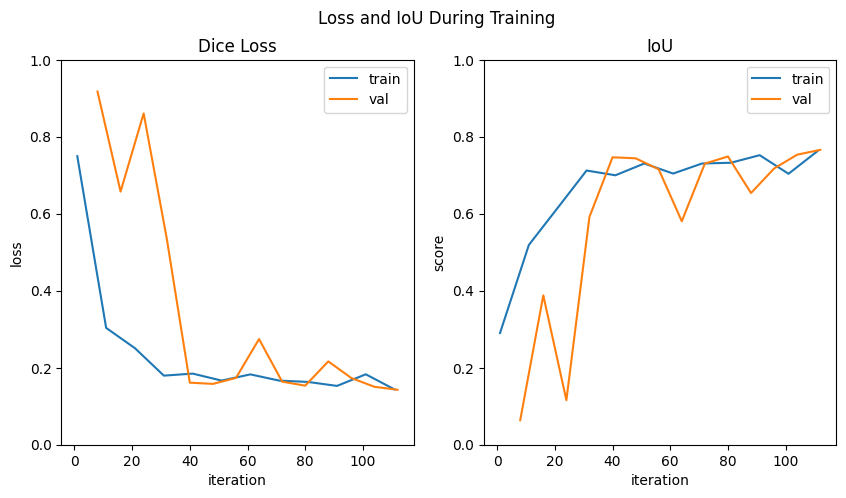

In [44]:
seg.plot_train(10);

In [45]:
res = seg.predict("test", scales=np.arange(8, 15, 0.5))
res["weighted_iou"]

Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [14:12<00:00, 20.31s/it]


0.7706138204471635

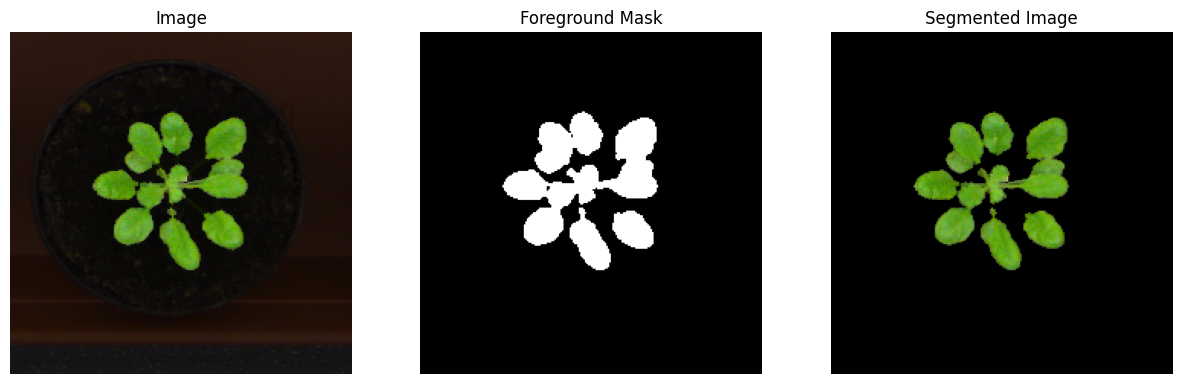

In [46]:
idx_to_show = 0
display_image(unnormalize(ds_test[idx_to_show][0].numpy()),
              res["predictions"][idx_to_show].cpu().numpy(), transpose_mask=True);

In [47]:
def plot_iou_distribution(ious):
    plt.hist(ious, bins=np.arange(0, 1.1, 0.1))
    plt.title("IoU Distribution")
    plt.xlabel("score")
    plt.ylabel("frequency")
    plt.xlim(0, 1)

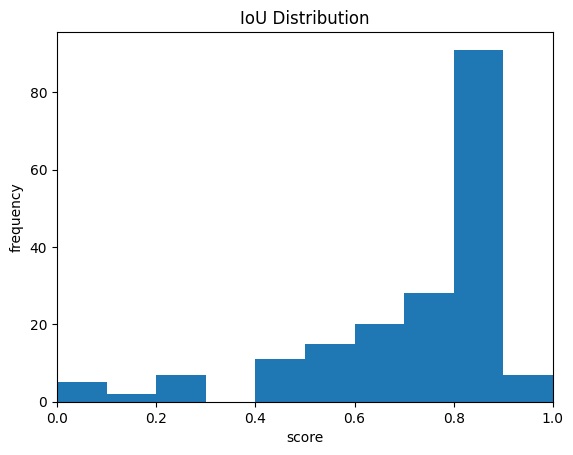

In [48]:
plot_iou_distribution(res["ious"]);

In [59]:
torch.save(seg.model.state_dict(), 'fcn_fintetuned.pth')

## Writeup

Summarize what you did above, as well as detail the choices you made and why. Concise descriptions in one paragraph is enough :)

---

*Apologies for the long-winded response—there's just too much to squeeze into a single paragraph!*

### Network architecture

We employ a Fully Convolutional Network (FCN) for semantic segmentation, using ResNet34 as the backbone. The input is an image of size $224\times224\times3$, and the model produces a $7\times7\times512$ feature map. A $1\times1$ convolutional layer is then applied to reduce the channel dimension to $3$, followed by a transposed convolution layer to upsample the output back to the original input size.

The transposed convolution follows the formula:

$$
224 = 6s – 2p + k
$$

where $s$ is stride, $p$ is padding and $k$ is kernel size. However, to allow more flexibility in choosing $s$, $p$, and $k$, we used a bilinear interpolation. This relaxes the constraints on transposed convolution by changing the $=$ sign above to $\ge$ sign.

### Evaluation metric

To account for the **large variability in leaf sizes** within the test set, we use a **weighted IoU metric**. Each sample's contribution to the overall score is weighted by the number of ground-truth leaf pixels it contains. This approach provides a more faithful representation of model performance, especially compared to the “average” IoU (which computes the IoU for each sample and averages them), found to over-penalize performance on smaller leaves, and the “micro” IoU (which takes all samples as a whole and computes IoU), which tends to under-penalize due to the dominance of large leaves with more leaf pixels.

### Image augmentation

A key component of our preprocessing pipeline is HSV color segmentation. We reduce the V (brightness) channel for non-green pixels to emphasize leaf regions. This preprocessing step significantly boosts model performance, increasing the IoU score by at least 0.25.

That said, the effectiveness of this step also highlights a concerning dependency: **performance is highly sensitive to HSV thresholds**. The model is over-reliant on the color-based preprocessing, rather than learning robust semantic features. In fact, it is likely that a simple deterministic HSV segmentation combined with morphological opening outperforms the model alone in most cases.

### Challenges

There are three majors sources of error which affects model performance:

1. Sharp and jagged edges in the segmentation masks.
2. Misclassification of moss as leaves.
3. Failure to detect bud leaves, which are often only a few pixels wide.

Challenges 1 and 3 are addressed effectively using the techniques described in the next section. However, for Challenge 2, I attempted to augment the dataset by adding artificial moss lumps:

```python
class RandomMossLumps(ColorEnhance):
    def __init__(self, n_lumps, max_blobs_per_lump, lower_hsv, upper_hsv, radius_range=(1, 3), spread_range=(-15, 15), p=0.8):
        super().__init__(lower_hsv, upper_hsv, p=p)
        self.n_lumps = n_lumps
        self.max_blobs_per_lump = max_blobs_per_lump
        self.radius_range = radius_range
        self.spread_range = spread_range


    def random_blob_color(self):
        h = random.randint(self.lower_hsv[0], self.upper_hsv[0])
        s = random.randint(self.lower_hsv[1], self.upper_hsv[1])
        v = random.randint(self.lower_hsv[2], self.upper_hsv[2])
        hsv = np.uint8([[[h, s, v]]])
        return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)[0, 0]
    
    
    def get_params_dependent_on_data(self, params, data):
        params["mask"] = data["mask"]
        return params
    
        
    def apply(self, image, **params):
        mask = params.get("mask", None)
        height, width = image.shape[:2]
        for _ in range(self.n_lumps):
            # center of a lump
            cx, cy = random.randint(0, width - 1), random.randint(0, height - 1)

            for _ in range(self.max_blobs_per_lump):
                dx = random.randint(*self.spread_range)
                dy = random.randint(*self.spread_range)
                x = np.clip(cx + dx, 0, width - 1)
                y = np.clip(cy + dy, 0, height - 1)
                r = random.randint(*self.radius_range)
    
                if mask is not None and mask[y, x, 0] != 0:
                    continue  # Don't draw on masked area
                
                color = self.random_blob_color()
                # Draw blob
                cv2.circle(image, (x, y), r, color.tolist(), -1)
        return image
```

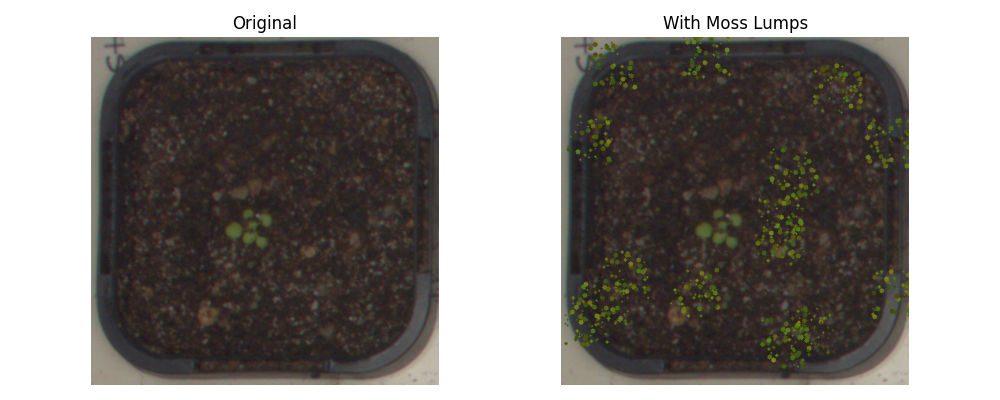

Unfortunately, this approach did not help the model improve its performance. the model is unable to learn the distinct characteristics of leaves compared to moss under the current setup.

### A better inference technique

To address both edge artifacts and the detection of small features (e.g., bud leaves), we introduced a **multiscale sliding window with soft voting**. During inference, the input images are zoomed at various factors and passed through sliding windows, with the probabilities for each zoom level being averaged to produce the final prediction.

Performance improved with both the zoom factor and the number of scales used, ultimately achieving an IoU score of about 0.77 on the test set.

## EX: Residual pathways

Here's something for you if you want to explore further.

FCNs are very simple and have some key architectural limitations. Depending on how your structured your network or processed your images, you might hit a performance limit even in this fairly simple dataset, even if you implement aggressive augmentations (_what's that?_). Try circumventing these limitations by implementing residual connections (_google me!_) in your network.

### Setup

In [49]:
from collections import OrderedDict

In [50]:
class ResidualFCN(FCN):
    RESNET34_OUT_SHAPES = (
        (64, 56, 56),  # layer0
        (64, 56, 56),  # layer1
        (128, 28, 28),  # layer2
        (256, 14, 14),  # layer3
        (512, 7, 7)  # layer4
    )
    __slots__ = ("in_channels", "stride", "padding", "res_conn_layer_idx", "kernel_size")

    def __init__(self, *, stride=1, padding=0, in_channels, res_conn_layer_idx):
        assert 0 <= res_conn_layer_idx <= 4, "'res_conn_layer_idx' must be an integer between 0 and 4'"
        self.in_channels = in_channels
        self.stride = stride
        self.padding = padding
        self.res_conn_layer_idx = res_conn_layer_idx

        resnet34 = models.resnet34(weights=ResNet34_Weights.DEFAULT)
        resnet34.avgpool = nn.Identity()
        resnet34.fc = nn.Identity()
        resnet34.layer0 = nn.Sequential(
            resnet34.conv1,
            resnet34.bn1,
            resnet34.relu,
            resnet34.maxpool
        )  # Custom property
        res_conn_out_channels, *res_conn_out_shape = self.RESNET34_OUT_SHAPES[res_conn_layer_idx]

        self.kernel_size = self.compute_kernel_size(res_conn_out_shape, padding=padding, stride=stride)
        head = nn.Sequential(OrderedDict([
            ("bottleneck", nn.Conv2d(512, in_channels, kernel_size=1)),
            ("upsample1", nn.Upsample(size=res_conn_out_shape, mode="bilinear")),
            ("conv_t", nn.ConvTranspose2d(in_channels + res_conn_out_channels, 1,
                                          kernel_size=self.kernel_size, stride=stride, padding=padding)),
            ("upsample2", nn.Sequential(
                nn.Upsample(size=224, mode="bilinear"),
                nn.Sigmoid()
            ))
        ]))
        super().__init__(resnet34, head)

    @staticmethod
    def compute_kernel_size(out_shape, *, padding, stride):
        p, s = map(lambda x: x if isinstance(x, Sequence) else (x, x), (padding, stride))
        in_shape = (7, 7)

        kernel_size = tuple(out_shape[i] - (in_shape[i] - 1) * s[i] + 2 * p[i] for i in range(2))
        return kernel_size[0] if kernel_size[0] == kernel_size[1] else kernel_size

    def forward(self, x):
        tmp = None
        for idx in range(5):
            layer_name = f"layer{idx}"
            x = self.backbone.__getattr__(layer_name)(x)
            if idx == self.res_conn_layer_idx:
                tmp = x

        x = self.head.bottleneck(x)
        x = self.head.upsample1(x)
        x = torch.cat([x, tmp], dim=1)  # residual connection
        x = self.head.conv_t(x)
        x = self.head.upsample2(x)
        return x

In [51]:
class ResidualBinaryImageSegmenter(BinaryImageSegmenter):
    __slots__ = ("in_channels", "res_conn_layer_idx")

    def __init__(self, data_loaders, *, lr, in_channels, stride, padding, res_conn_layer_idx, l2_penalty=0):
        self.in_channels = in_channels
        self.res_conn_layer_idx = res_conn_layer_idx
        super().__init__(data_loaders, lr=lr, stride=stride, padding=padding, l2_penalty=l2_penalty, kernel_size=-1)
        self.kernel_size = self.model.kernel_size

    def reload_model(self, *, stride=None, padding=None, in_channels=None, res_conn_layer_idx=None):
        if stride is not None:
            self.stride = stride
        if padding is not None:
            self.padding = padding
        if in_channels is not None:
            self.in_channels = in_channels
        if res_conn_layer_idx is not None:
            self.res_conn_layer_idx = res_conn_layer_idx

        self._set_seed()
        self.model = ResidualFCN(stride=self.stride, padding=self.padding,
                                 in_channels=self.in_channels, res_conn_layer_idx=self.res_conn_layer_idx).to(
            self.device)
        self._reload_optimizer()


### Finetuning

In [52]:
ds_trainval1, ds_test1 = create_dataset()
dl_train1, dl_val1, dl_test1 = create_dataloader(ds_trainval1, ds_test1)

In [53]:
seg1 = ResidualBinaryImageSegmenter((dl_train1, dl_val1, dl_test1), in_channels=4, res_conn_layer_idx=2,
                                    lr=0.0021855108490950246, padding=7, stride=4, l2_penalty=0.0012771973203875206)

In [54]:
seg1.fit(29);

Training: 100%|████████████████████████████████████████████████████████████████████████████████████████| 232/232 [02:33<00:00,  1.52it/s, loss=0.0378]


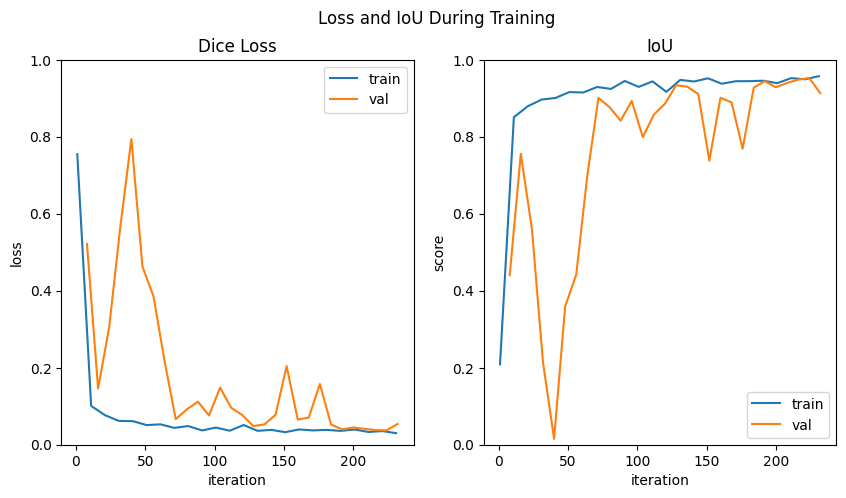

In [55]:
seg1.plot_train(10);

In [56]:
res1 = seg1.predict("test", scales=(3, ))
res1["weighted_iou"]

Testing: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:11<00:00,  3.79s/it]


0.822281182313563

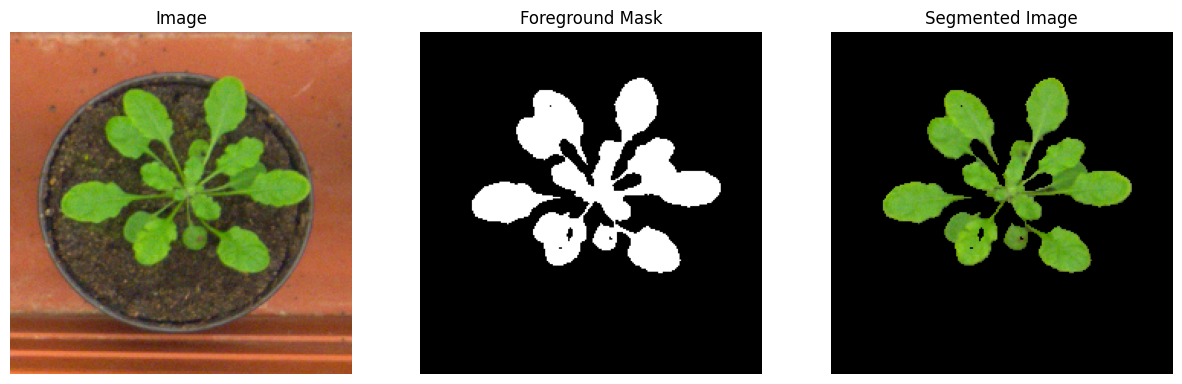

In [57]:
idx_to_show = 93
display_image(unnormalize(ds_test1[idx_to_show][0].numpy()),
              res1["predictions"][idx_to_show].cpu().numpy(), transpose_mask=True);

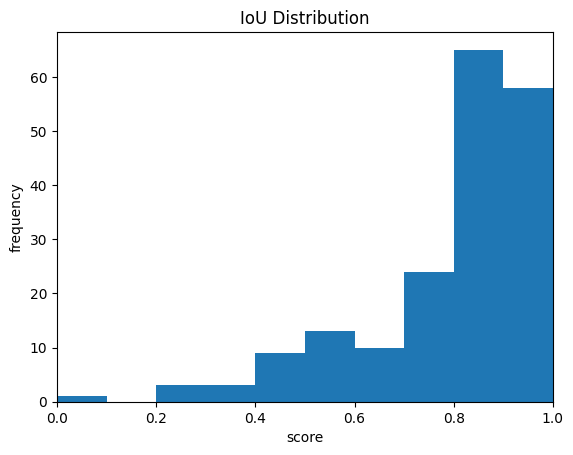

In [58]:
plot_iou_distribution(res1["ious"]);

In [60]:
torch.save(seg1.model.state_dict(), 'rfcn_fintetuned.pth')

### Conclusion

The network is structured as follows:

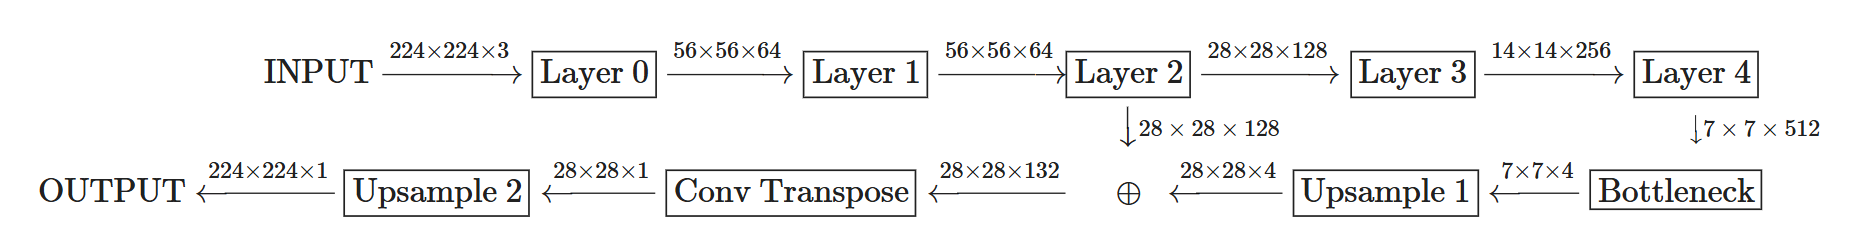

<!--
$$
\begin{aligned}
\text{INPUT} \xrightarrow{224\times224\times3} \boxed{\text{Layer\ 0}} \xrightarrow{56\times56\times64} \boxed{\text{Layer\ 1}} \xrightarrow{56\times56\times64} &\boxed{\text{Layer\ 2}} \xrightarrow{28\times28\times128} \boxed{\text{Layer\ 3}} \xrightarrow{14\times14\times256} \boxed{\text{Layer\ 4}}\\
&\ \ \ \ \ \ \big\downarrow \tiny{28\times28\times128} \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \big\downarrow \tiny{7\times7\times512} \\
\text{OUTPUT} \xleftarrow{224\times224\times1} \boxed{\text{Upsample 2}} \xleftarrow{28\times28\times1} \boxed{\text{Conv\ Transpose}} \xleftarrow{28\times28\times132} &\ \ \ \ \ \oplus\ \xleftarrow{28\times28\times4} \boxed{\text{Upsample 1}} \xleftarrow{7\times7\times4} \boxed{\text{Bottleneck}}
\end{aligned}
$$
-->

where $\oplus$ denotes the stacking of the outputs from two layers.

With the addition of the residual connection, the model achieves a weighted IoU score of 0.82 without any data augmentation. Moreover, a significantly larger proportion of test images achieve scores above 0.8 compared to the previous model. Images with very low scores are primarily those containing bud leaves, which cannot be resolved simply by applying zoom during inference. This suggests that the model is learning meaningful leaf features rather than relying solely on color cues.